## Comparaison des distances sur des simulations de modèles de ressorts perturbés

Chaque jeu de simulation a été simulé pour des paramètres `(F, k)` fixés. Le bruit et les conditions intiales sont aléatoires et varient selon chaque simulation.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
from tqdm import tqdm
import pickle

from descriptor import compute_descriptor
from wasserstein_distance import compute_wasserstein_distance
from kolmogorov_distance import compute_kolmogorov_dist
from data_functions import load_data, plot_data
import simu_ressort

### Load data

In [2]:
all_simus = simu_ressort.load_obj("./data/ressort/simus.pkl")

print("{} parameters tested, and {} simus for each parameter.".format(len(all_simus),
                                                                      all_simus[0]['N']))
print("The duration of each simu is {} dt.".format(np.shape(all_simus[0]['simu'])[1]))

100 parameters tested, and 100 simus for each parameter.
The duration of each simu is 500 dt.


`all_simu` contient les simulations, chaque élément contient les paramètres et toutes les simulations effectuées avec ces paramètres dans l'item `simu`

In [3]:
all_simus[0]

{'F': 0.0,
 'N': 100,
 'Vmax': 6,
 'Vmin': 0.5,
 'k': 0.0,
 'simu': array([[ -3.94965903e+00,   3.86265407e-01,   4.24861689e+00, ...,
          -2.48588604e+03,  -2.49350395e+03,  -2.50262021e+03],
        [ -4.45514585e+00,   3.00516023e+00,   1.00309190e+01, ...,
           4.35343761e+03,   4.36663990e+03,   4.37807314e+03],
        [ -6.89872569e-01,  -3.29654957e+00,  -5.65436832e+00, ...,
          -4.35711734e+03,  -4.39327884e+03,  -4.42802763e+03],
        ..., 
        [ -2.19715552e+00,  -4.30963699e+00,  -6.73227731e+00, ...,
           5.35208146e+03,   5.37638871e+03,   5.39962114e+03],
        [ -3.74831563e+00,  -3.51573651e+00,  -1.29991912e+00, ...,
          -1.97802384e+03,  -1.97377444e+03,  -1.96960677e+03],
        [  2.24480341e+00,   3.96651784e-01,  -2.96918607e+00, ...,
           4.30849771e+03,   4.33519354e+03,   4.36292706e+03]])}

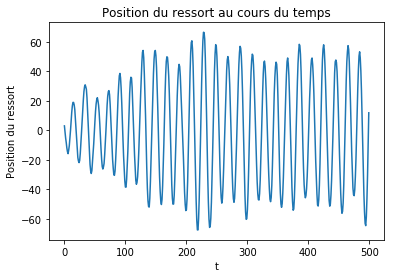

In [4]:
i, j = 10, 10
simu_ressort.plot_ressort(all_simus[i]['simu'][j, :], F=all_simus[i]['F'], k=all_simus[i]['k'])

#### Mettre sous la forme DataFrame comme les simus de poumons
Format qu'il faudrait que l'on change parce qu'il est pas ouf mais bon...

In [5]:
sets = simu_ressort.transform_simus_to_df(all_simus, nmax=100)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 645.55it/s]


In [6]:
def plot_df(df, nmax=None):
    if not nmax:
        nmax = df.shape[1]
    for col in df.columns[:nmax]:
        df[col].plot()
    plt.show()

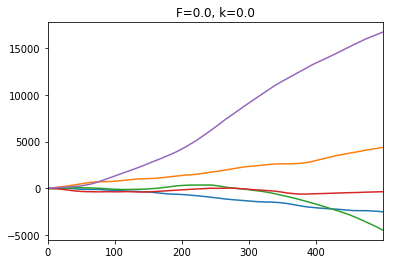

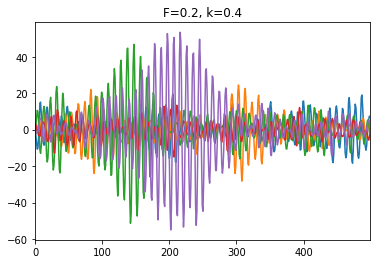

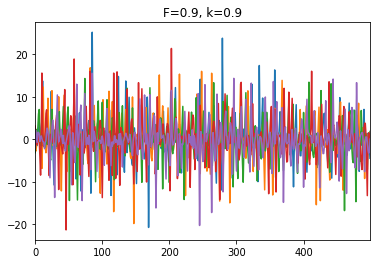

In [7]:
# Exemples de simus

plt.title("F={}, k={}".format(all_simus[0]['F'],all_simus[0]['k']))
plot_df(sets[0], nmax=5)

i = 42
plt.title("F={}, k={}".format(all_simus[i]['F'], all_simus[i]['k']))
plot_df(sets[i], nmax=5)

i = 99
plt.title("F={}, k={}".format(all_simus[i]['F'], all_simus[i]['k']))
plot_df(sets[i], nmax=5)

In [8]:
df1 = sets[0]
df1.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99
0,-3.949659,-4.455146,-0.689873,1.485345,-3.033292,2.383179,-3.456266,-2.847746,1.485573,3.535218,...,4.741835,3.790267,-0.811013,-4.691876,-1.940194,1.446211,2.547238,-2.197156,-3.748316,2.244803
1,0.386265,3.005160,-3.296550,-0.691042,2.815082,-0.430989,-4.933992,0.833832,1.941403,3.951765,...,-1.915535,-2.912630,-4.353645,0.924109,-1.687948,-2.914992,4.443916,-4.309637,-3.515737,0.396652
2,4.248617,10.030919,-5.654368,-2.517534,8.491184,-2.339693,-5.180501,4.210704,1.093957,3.951589,...,-8.876938,-10.597683,-5.585349,5.041469,-2.658401,-9.340286,6.127958,-6.732277,-1.299919,-2.969186
3,9.331746,18.319582,-7.594296,-4.426280,15.147612,-4.032092,-5.889517,7.441145,0.503544,3.570196,...,-16.280589,-19.395999,-8.395239,10.172219,-4.680209,-16.851103,7.537712,-10.420143,1.219740,-6.744193
4,14.427589,26.377142,-9.525022,-6.233633,22.549909,-3.699043,-5.991273,8.499223,0.269619,4.444506,...,-24.126466,-28.555013,-11.643617,15.191708,-6.202481,-24.332247,10.106493,-14.661426,5.177858,-10.360730


In [9]:
compute_kolmogorov_dist(sets[0], sets[42]), compute_kolmogorov_dist(sets[41], sets[42])

(0.99999999999997191, 0.95185610298445567)

In [10]:
start_time = time.time()
d = compute_wasserstein_distance(sets[0], sets[42])
print("Execution time: {} min".format(round((time.time() - start_time) / 60, 2)))
print("Distance:", d)

Execution time: 0.47 min
Distance: 983130.609196


### Calculer les distances entre chaque couple de simus

In [11]:
def compute_dist_sets(sets):
    distances = []
    
    for df1 in tqdm(sets):
    #for df1 in [sets[42]]:
        for df2 in tqdm(sets):
            kolm_dist = compute_kolmogorov_dist(df1, df2)
            wasser_dist = compute_wasserstein_distance(df1, df2)
            distances.append([kolm_dist, wasser_dist])
            
    return np.array(distances)

def plot_comparaison(distances):
    plt.scatter(distances[:, 0], distances[:, 1], marker='x')
    plt.xlabel("Kolmogorov distance")
    plt.ylabel("Wasserstein distance")
    plt.title("Comparaison des distances")
    plt.show()

In [12]:
distances = compute_dist_sets(sets)

save_obj(distances, './data/distances_ressort.pkl')

  1%|▊                                                                                 | 1/100 [00:00<00:18,  5.46it/s]



KeyboardInterrupt: 

In [ ]:
plot_comparaison(distances)

In [ ]:
distances

In [ ]:
plt.scatter(distances[:20, 0], distances[:20, 1], marker='x')
plt.show()